In [1]:
#!kaggle datasets download -d anshtanwar/jellyfish-types

# START

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

In [3]:
IMG_SIZE = 64

In [4]:
plt.rcParams["savefig.bbox"] = 'tight'

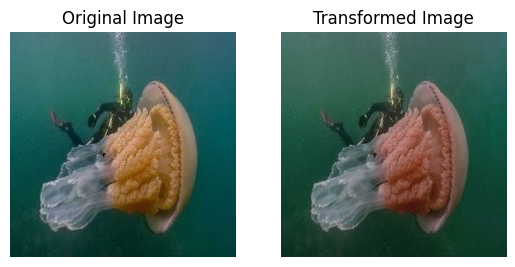

In [5]:
# Load the image
image_path = 'Train_Test_Valid/train/barrel_jellyfish/17.jpg'  # Replace with the path to your image
original_image = Image.open(image_path).convert("RGB")

# Define the transformation
transform = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)
# Apply the transformation
transformed_image = transform(original_image)


# Display the original and transformed images
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(transformed_image)
plt.title('Transformed Image')
plt.axis('off')


plt.show()

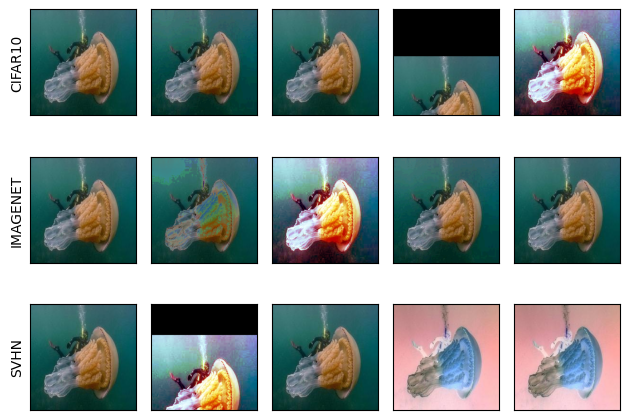

In [6]:
from torchvision.transforms import v2
from helpers import plot
policies = [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
augmenters = [v2.AutoAugment(policy) for policy in policies]
imgs = [
    [augmenter(original_image) for _ in range(4)]
    for augmenter in augmenters
]
row_title = [str(policy).split('.')[-1] for policy in policies]
plot([[original_image] + row for row in imgs], row_title=row_title)

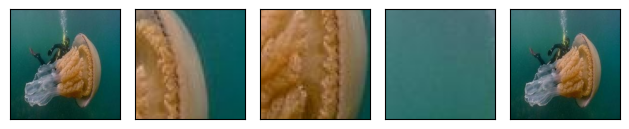

In [7]:
applier = v2.RandomApply(transforms=[v2.RandomCrop(size=(64, 64))], p=0.5)
transformed_imgs = [applier(original_image) for _ in range(4)]
plot([original_image] + transformed_imgs)

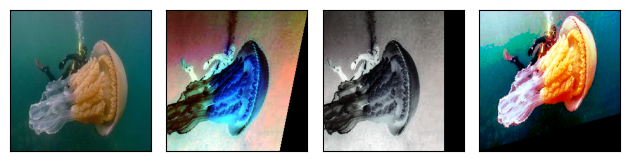

In [8]:
applier = v2.RandomApply(transforms=[v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET),
                                    v2.AutoAugment(v2.AutoAugmentPolicy.CIFAR10),
                                     v2.AutoAugment(v2.AutoAugmentPolicy.SVHN)
                                    ], p=0.8)

transformed_imgs = [applier(original_image) for _ in range(3)]

plot([original_image] + transformed_imgs)

# Test GPU

In [9]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0))

True 1 0 <torch.cuda.device object at 0x7f14f533ad90> NVIDIA GeForce RTX 3050 Ti Laptop GPU


# Dataset

In [10]:
policies = [v2.AutoAugmentPolicy.CIFAR10, v2.AutoAugmentPolicy.IMAGENET, v2.AutoAugmentPolicy.SVHN]
augmenters = [v2.AutoAugment(policy) for policy in policies]

train_transform = transforms.Compose([
    v2.RandomApply(transforms=augmenters, p=0.8),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])


In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.dataset = datasets.ImageFolder(root=os.path.join(root, split), transform=transform)
        self.classes = self.dataset.classes

    def __getitem__(self, index):
        return self.dataset[index]

    def __len__(self):
        return len(self.dataset)
        
dataset_root = 'Train_Test_Valid'

# Create datasets with and without augmentation
#train_dataset_augmented = CustomDatasetWithAugmentation(root=dataset_root, split='train', transform=train_transform)
train_dataset = CustomDataset(root=dataset_root, split='train', transform=train_transform)
test_dataset = CustomDataset(root=dataset_root, split='test', transform=val_test_transform)
valid_dataset = CustomDataset(root=dataset_root, split='valid', transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

In [12]:
train_loader.dataset.__len__(), test_loader.dataset.__len__(), valid_loader.dataset.__len__()

(900, 40, 39)

# VGG16

In [13]:
import torch
from torchvision import models
from torchinfo import summary


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg = models.vgg16().to(device)
summary(vgg, input_size=(32, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [32, 1000]                --
├─Sequential: 1-1                        [32, 512, 2, 2]           --
│    └─Conv2d: 2-1                       [32, 64, 64, 64]          1,792
│    └─ReLU: 2-2                         [32, 64, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 64, 64, 64]          36,928
│    └─ReLU: 2-4                         [32, 64, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 64, 32, 32]          --
│    └─Conv2d: 2-6                       [32, 128, 32, 32]         73,856
│    └─ReLU: 2-7                         [32, 128, 32, 32]         --
│    └─Conv2d: 2-8                       [32, 128, 32, 32]         147,584
│    └─ReLU: 2-9                         [32, 128, 32, 32]         --
│    └─MaxPool2d: 2-10                   [32, 128, 16, 16]         --
│    └─Conv2d: 2-11                      [32, 256, 16, 16]         29

In [15]:
from torch import optim
from torch import nn 
vgg.classifier[6] = nn.Linear(4096, 6).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.parameters(), lr=0.001)

# Training loop
num_epochs = 200

for epoch in range(num_epochs):
    vgg.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Validation loop
    vgg.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = vgg(inputs)
            _, predicted = torch.max(outputs, 1)

            total_samples += labels.size(0)
            total_correct += (predicted == labels).sum().item()

    accuracy = total_correct / total_samples
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item():.4f}, Validation Accuracy: {accuracy:.4f}')

# Testing loop
vgg.eval()
total_correct = 0
total_samples = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = vgg(inputs)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

test_accuracy = total_correct / total_samples
print(f'Test Accuracy: {test_accuracy:.4f}')

Epoch 1/200, Loss: 1.7974, Validation Accuracy: 0.1795
Epoch 2/200, Loss: 1.7969, Validation Accuracy: 0.1538
Epoch 3/200, Loss: 1.7841, Validation Accuracy: 0.1795
Epoch 4/200, Loss: 1.7926, Validation Accuracy: 0.1795
Epoch 5/200, Loss: 1.8240, Validation Accuracy: 0.1795
Epoch 6/200, Loss: 1.7974, Validation Accuracy: 0.1795
Epoch 7/200, Loss: 1.7997, Validation Accuracy: 0.1795
Epoch 8/200, Loss: 1.7895, Validation Accuracy: 0.1795
Epoch 9/200, Loss: 1.7903, Validation Accuracy: 0.1538
Epoch 10/200, Loss: 1.7896, Validation Accuracy: 0.1538
Epoch 11/200, Loss: 1.7944, Validation Accuracy: 0.1538
Epoch 12/200, Loss: 1.7986, Validation Accuracy: 0.1282
Epoch 13/200, Loss: 1.7957, Validation Accuracy: 0.1795
Epoch 14/200, Loss: 1.8015, Validation Accuracy: 0.1795
Epoch 15/200, Loss: 1.7870, Validation Accuracy: 0.1795
Epoch 16/200, Loss: 1.7939, Validation Accuracy: 0.1795
Epoch 17/200, Loss: 1.7962, Validation Accuracy: 0.1795
Epoch 18/200, Loss: 1.7920, Validation Accuracy: 0.1282
E